In [7]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d", base_dir, sample_rate=1.0)
X.info()

0it [00:00, ?it/s]

34it [00:18,  1.14it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:26,  1.21it/s]

< 0 found in file time.128.512.0.pkl


46it [00:28,  1.15it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:35,  1.32it/s]

< 0 found in file time.512.128.0.pkl


56it [00:37,  1.20it/s]

< 0 found in file time.512.512.0.pkl


58it [00:39,  1.14it/s]

< 0 found in file time.512.1024.0.pkl


59it [00:40,  1.08s/it]

< 0 found in file time.512.1024.1.pkl


64it [00:43,  1.53it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:45,  1.30it/s]

< 0 found in file time.1024.128.0.pkl


68it [00:47,  1.11it/s]

< 0 found in file time.1024.512.0.pkl


69it [00:49,  1.15s/it]

< 0 found in file time.1024.512.1.pkl


70it [00:49,  1.04it/s]

< 0 found in file time.1024.1024.0.pkl


71it [00:51,  1.17s/it]

< 0 found in file time.1024.1024.1.pkl


72it [00:52,  1.38it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685125 entries, 0 to 685124
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             685125 non-null  int64  
 1   in_channels   685125 non-null  int64  
 2   iH            685125 non-null  int64  
 3   iW            685125 non-null  int64  
 4   out_channels  685125 non-null  int64  
 5   groups        685125 non-null  int64  
 6   kH            685125 non-null  int64  
 7   kW            685125 non-null  int64  
 8   stride        685125 non-null  int64  
 9   dilation      685125 non-null  int64  
 10  oH            685125 non-null  int64  
 11  oW            685125 non-null  int64  
 12  gflops        685125 non-null  float64
 13  dtype_16      685125 non-null  bool   
 14  dtype_32      685125 non-null  bool   
 15  dtype_b16     685125 non-null  bool   
 16  transposed_0  685125 non-null  bool   
 17  transposed_1  685125 non-null  bool   
dtypes: b

In [3]:
df = pd.concat([X, y], axis=1)
df = df.query("time > 0").dropna()
X, y = df.drop(["time"], axis=1), df["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444058 entries, 178626 to 121958
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             444058 non-null  int64  
 1   in_channels   444058 non-null  int64  
 2   iH            444058 non-null  int64  
 3   iW            444058 non-null  int64  
 4   out_channels  444058 non-null  int64  
 5   groups        444058 non-null  int64  
 6   kH            444058 non-null  int64  
 7   kW            444058 non-null  int64  
 8   stride        444058 non-null  int64  
 9   dilation      444058 non-null  int64  
 10  oH            444058 non-null  int64  
 11  oW            444058 non-null  int64  
 12  gflops        444058 non-null  float64
 13  dtype_16      444058 non-null  bool   
 14  dtype_32      444058 non-null  bool   
 15  dtype_b16     444058 non-null  bool   
 16  transposed_0  444058 non-null  bool   
 17  transposed_1  444058 non-null  bool   
dtypes: b

# Fitting

## Decision Tree

Train--------
Mean Squared Error: 6184.940281304061
MAPE: 0.03388707084541797
R-squared: 0.9883166746666038


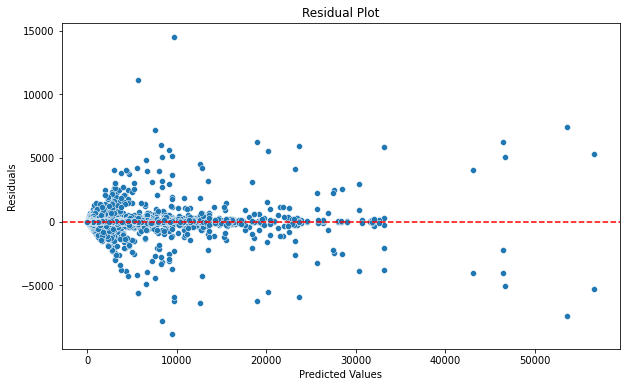

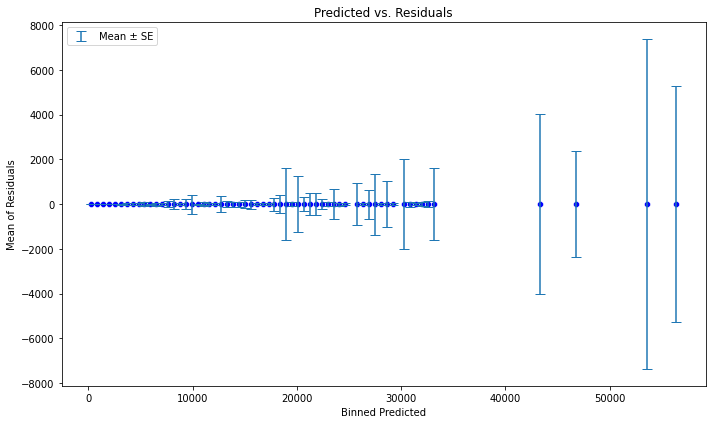

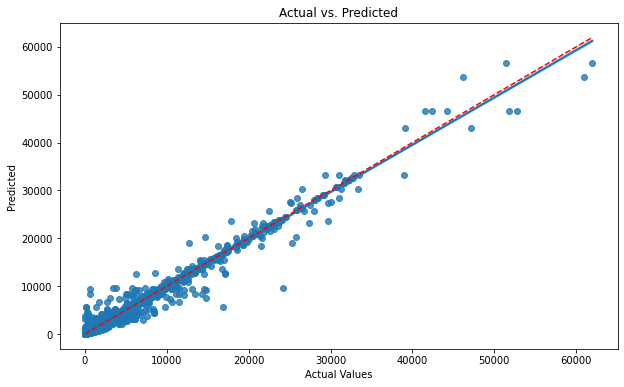

Val--------
Mean Squared Error: 28757.173689115898
MAPE: 0.12354952810630977
R-squared: 0.9413885772331513


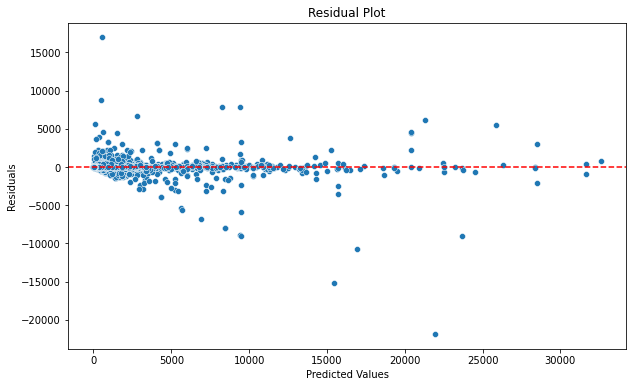

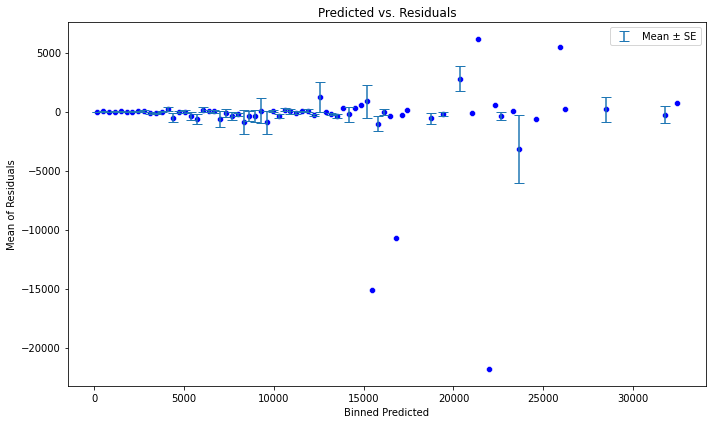

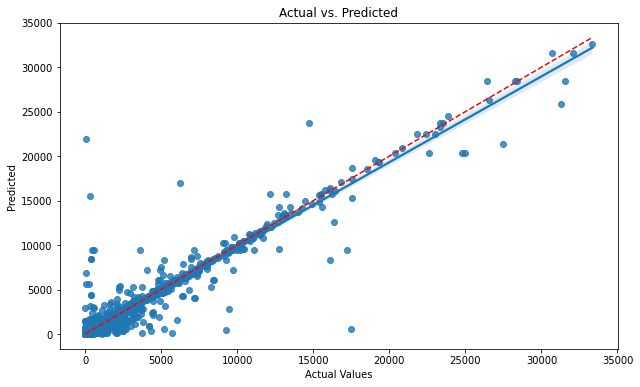

In [6]:
tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

y_train_res = y_hat_train - y_train

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [7]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)
features_df

,Feature,Importance
12,gflops,0.593951
14,dtype_32,0.104444
5,groups,0.047286
1,in_channels,0.043474
0,b,0.042410
4,out_channels,0.037504
7,kW,0.028076
6,kH,0.026680
13,dtype_16,0.025307
17,transposed_1,0.022073


## Decision Tree + Log Transform

Train--------
Mean Squared Error: 12599.064889681951
MAPE: 0.02859485124199375
R-squared: 0.9753516564740572


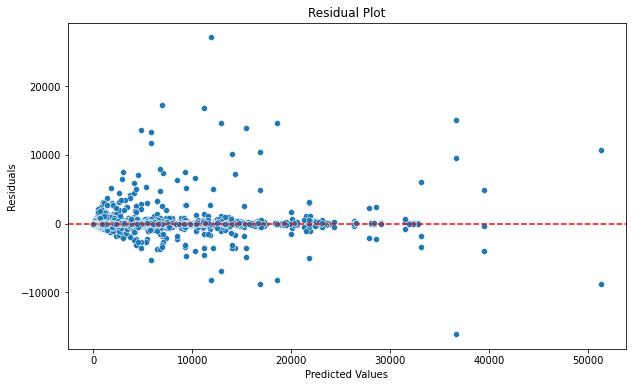

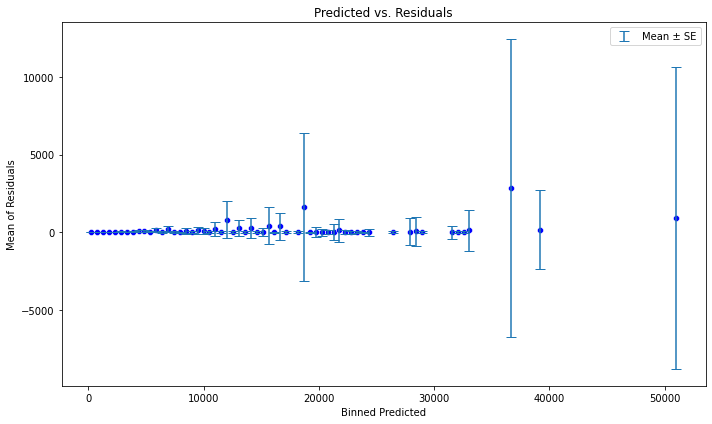

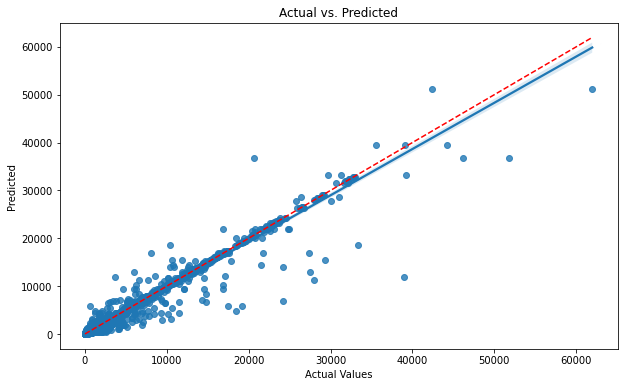

Val--------
Mean Squared Error: 97824.16505533425
MAPE: 0.1022318259034057
R-squared: 0.8101045972947556


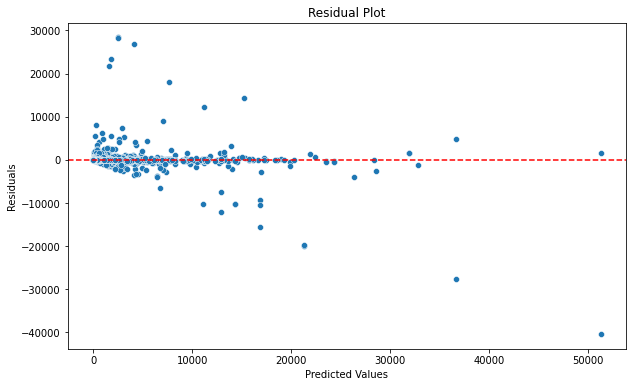

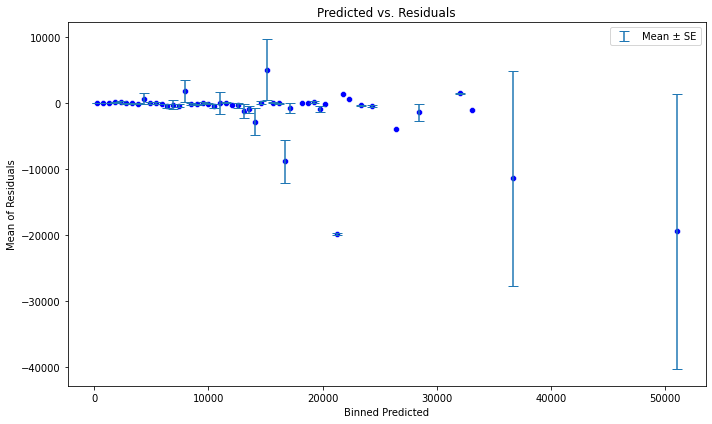

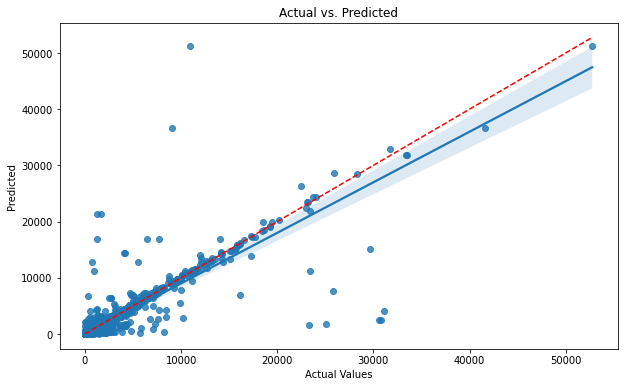

In [4]:
y_train_log = np.log1p(y_train.copy())

tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train_log)

y_hat_train = np.expm1(tree_model.predict(X_train))
y_hat_val = np.expm1(tree_model.predict(X_val))

y_train_res = y_hat_train - y_train

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

## Random Forest

In [8]:
tree_model = RandomForestRegressor(n_estimators=30, max_depth=25, random_state=random_seed)
tree_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=30, random_state=42)

Train--------
Mean Squared Error: 6896.009054840728
MAPE: 0.06181300185673287
R-squared: 0.9869734688411959


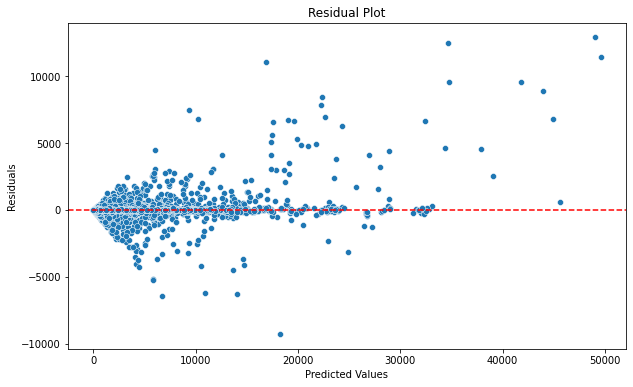

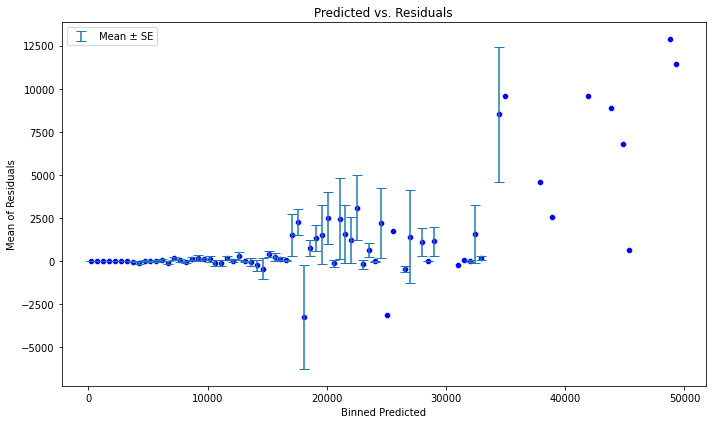

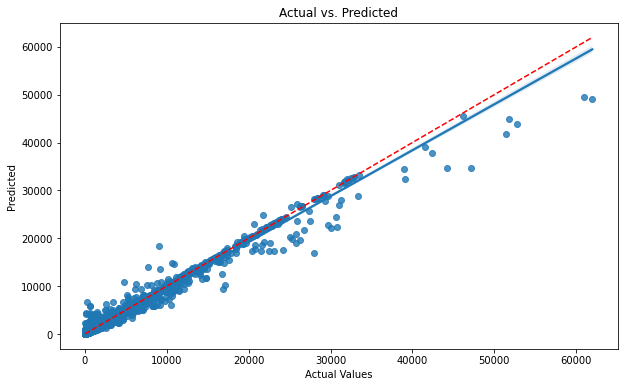

Val--------
Mean Squared Error: 19392.402860115417
MAPE: 0.13343447962374988
R-squared: 0.9604753813852903


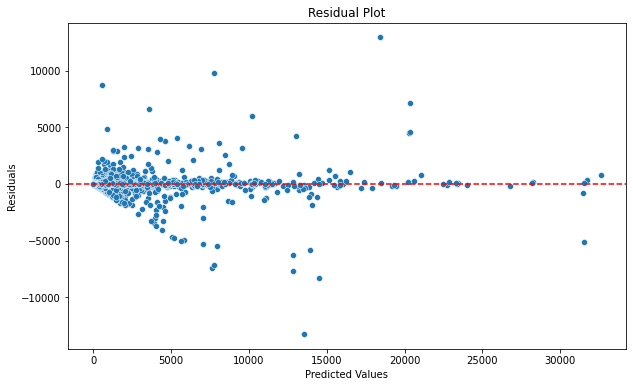

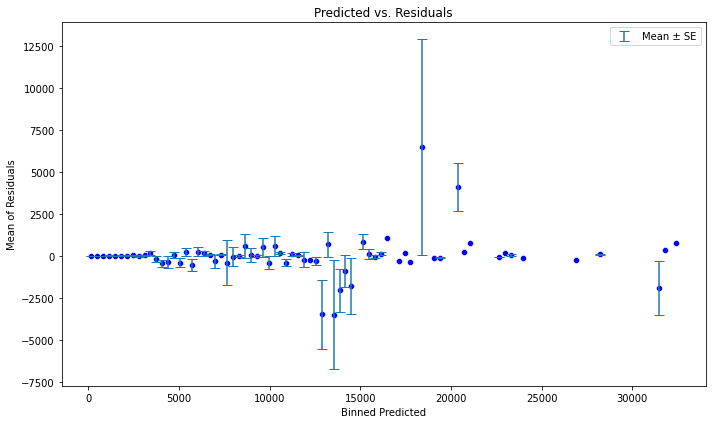

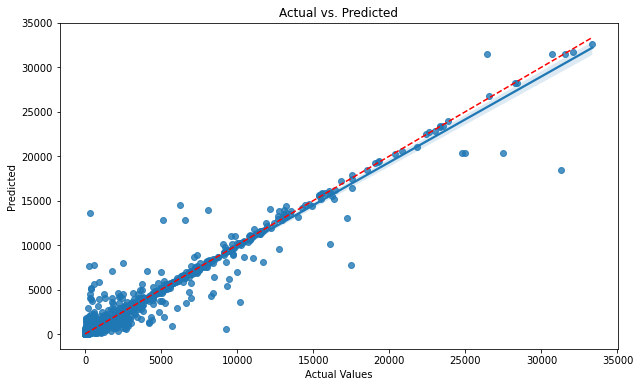

In [9]:
y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [10]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
)

features_df = features_df.sort_values(by="Importance", ascending=False)
features_df

,Feature,Importance
12,gflops,0.602554
14,dtype_32,0.101973
5,groups,0.053465
4,out_channels,0.042646
0,b,0.034037
1,in_channels,0.031839
13,dtype_16,0.031268
7,kW,0.020551
16,transposed_0,0.020248
17,transposed_1,0.018797


# Log Transform + Random Forest

Train--------
Mean Squared Error: 31990.500215557764
MAPE: 0.05211537338122289
R-squared: 0.9374149712074608


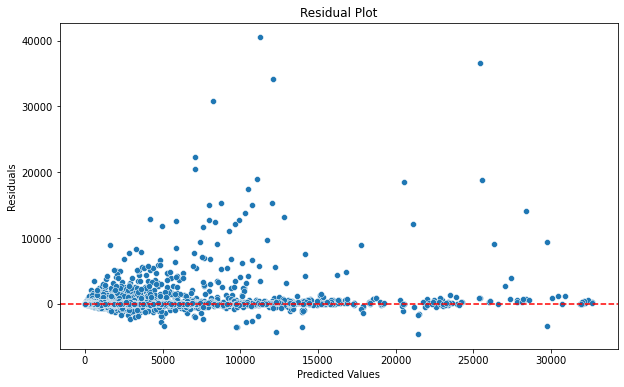

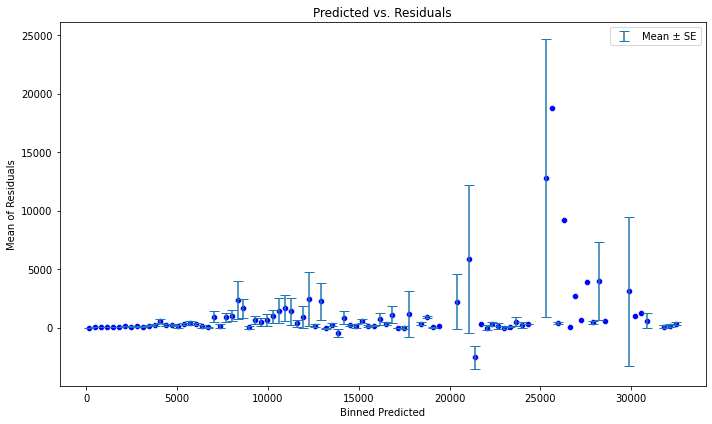

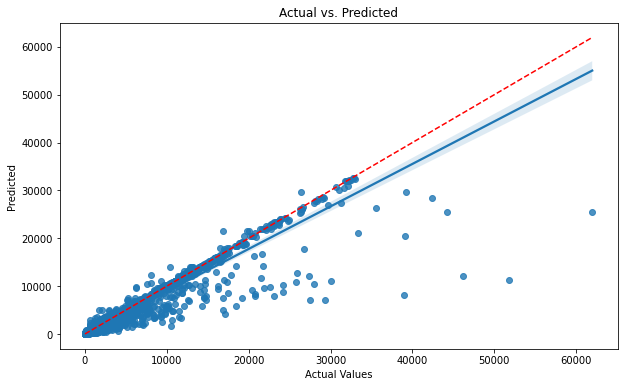

Val--------
Mean Squared Error: 79087.78820802315
MAPE: 0.09979826280165849
R-squared: 0.8464754860689638


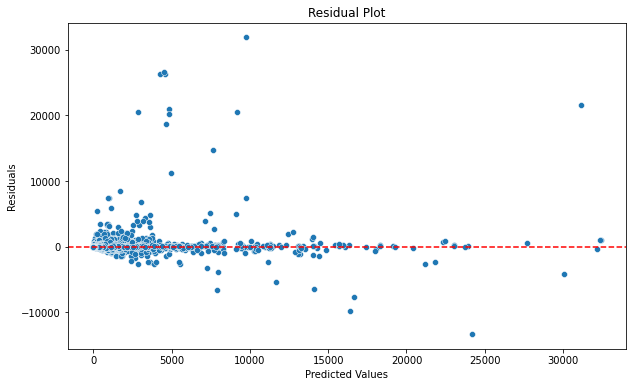

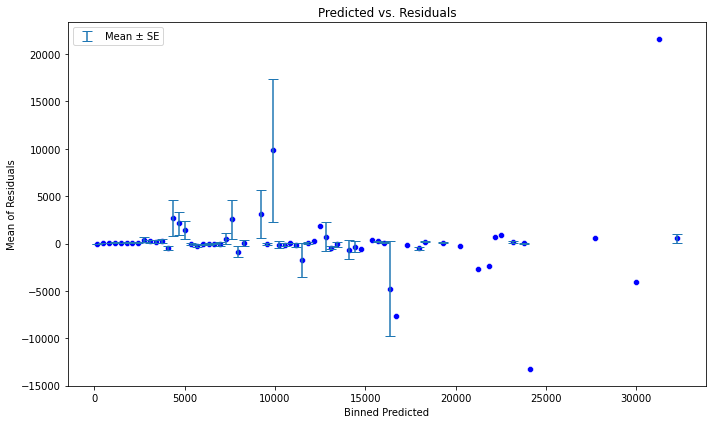

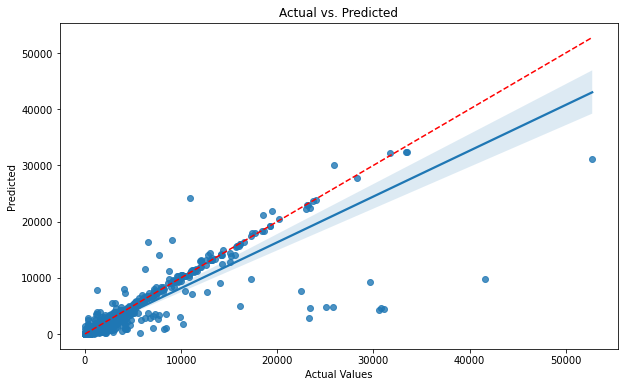

In [5]:
y_train_log = np.log1p(y_train.copy())

tree_model = RandomForestRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train_log)

y_hat_train = np.expm1(tree_model.predict(X_train))
y_hat_val = np.expm1(tree_model.predict(X_val))

y_train_res = y_hat_train - y_train

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

# Try clipping the range of values

# What's up with the underpredicted large values?

Might be throttling.

In [10]:
df.query("time > 30000")

,b,in_channels,iH,iW,out_channels,groups,kH,kW,stride,dilation,gflops,dtype_16,dtype_32,dtype_b16,transposed_0,transposed_1,time
342133,32,3072,128,1024,3072,1024,7,5,1,1,2.770769e+06,True,False,False,False,True,31279.931641
343569,32,3072,128,1024,3072,1024,3,5,1,1,1.187473e+06,True,False,False,False,True,42441.984375
343627,32,3072,128,1024,3072,1024,5,3,1,1,1.187473e+06,True,False,False,False,True,47111.929688
345213,32,3072,128,1024,3072,1024,7,3,1,1,1.662462e+06,True,False,False,False,True,61956.699219
345370,32,2048,128,1024,2048,1024,7,3,1,1,7.388718e+05,True,False,False,False,True,30083.922852
345889,32,3072,128,1024,3072,1024,7,7,1,1,3.879077e+06,True,False,False,False,True,39196.076172
346249,32,3072,128,1024,3072,512,5,3,1,1,1.187473e+06,True,False,False,False,True,31108.275391
347205,32,3072,128,1024,3072,512,7,3,1,1,1.662462e+06,True,False,False,False,True,31308.554688
348185,32,3072,128,1024,3072,1024,3,7,1,1,1.662462e+06,True,False,False,False,True,52762.773438
411346,32,1536,512,512,1536,256,7,3,1,1,8.312308e+05,True,False,False,False,True,30828.345703


# GridsearchCV

In [10]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

param_grid = {
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [2, 10, 20],
    "max_features": [50, 100, 1.0, "sqrt"],
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring=make_scorer(r2_score),
    cv=5,
    # verbose=2,
    n_jobs=-1,
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  0.6870819071569367


In [11]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=20, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 9982.444637877275
MAPE: 0.23103490969705714
R-squared: 0.9645004139536991


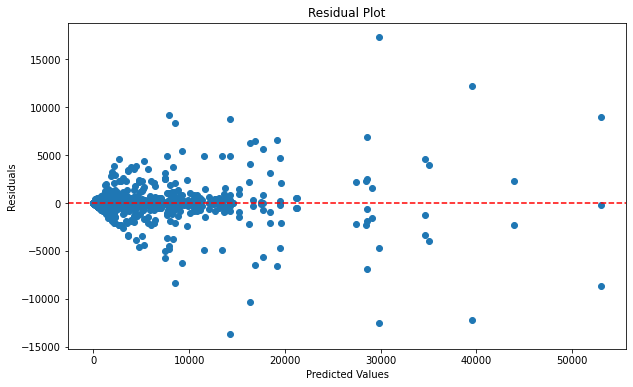

Val--------
Mean Squared Error: 38646.79429864945
MAPE: 0.282881790979092
R-squared: 0.8377715080308532


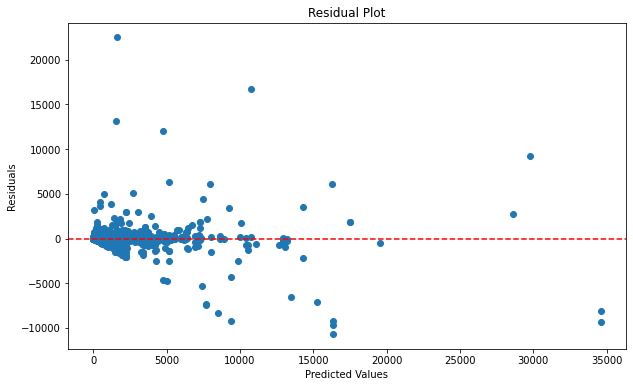

In [12]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)

In [13]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 1.0, 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),  # Use R-squared as the performance metric
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 40, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  -0.1586529198468168


In [14]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=40, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 9981.278646099066
MAPE: 0.0405494762183794
R-squared: 0.9645045604555793


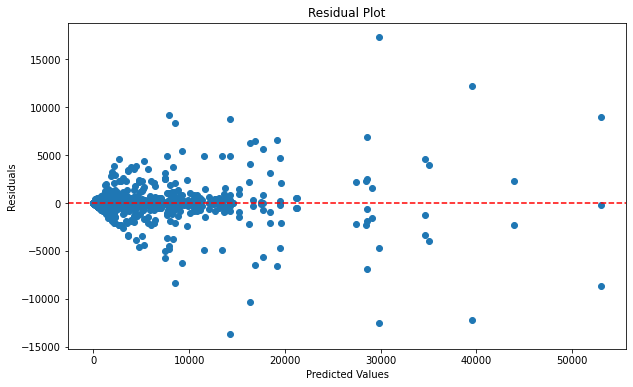

Val--------
Mean Squared Error: 38808.70579884653
MAPE: 0.13223612595628043
R-squared: 0.8370918485924415


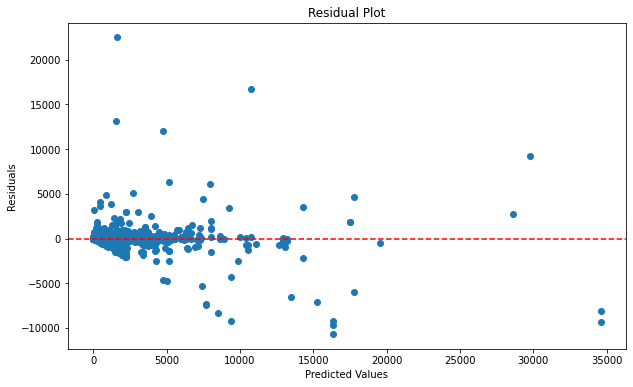

In [15]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [16]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 1.0, 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  -84025.7469057844


In [17]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=20, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 9982.444637877275
MAPE: 0.23103490969705714
R-squared: 0.9645004139536991


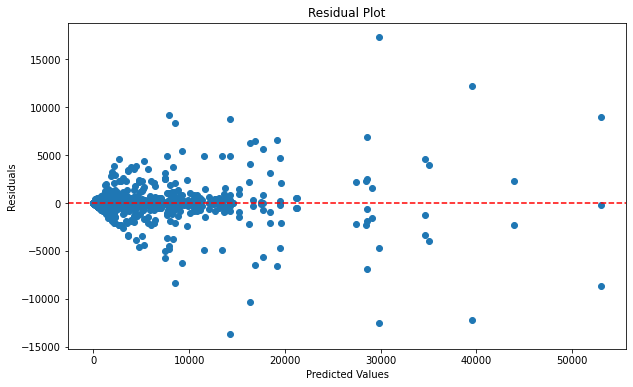

Val--------
Mean Squared Error: 38646.79429864945
MAPE: 0.282881790979092
R-squared: 0.8377715080308532


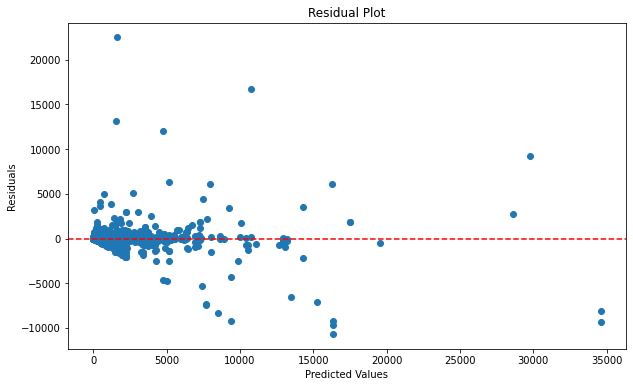

In [18]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)

# GridSearchCV

In [18]:
tree_model = RandomForestRegressor(random_state=random_seed)

param_grid = {
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [2, 10, 20],
    "max_features": [50, 100, 1.0, "sqrt"],
}

y_train_log = np.log1p(y_train)

def log_mse_scorer(y_true, y_pred):
    # Apply inverse log transformation to predictions
    y_pred_orig = np.expm1(y_pred)
    y_true_orig = np.expm1(y_true)
    return mean_squared_error(y_true_orig, y_pred_orig)

grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring=make_scorer(log_mse_scorer, greater_is_better=False),
    cv=5,
    # verbose=2,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train_log)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

/opt/miniconda3/envs/research/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

<Axes: >

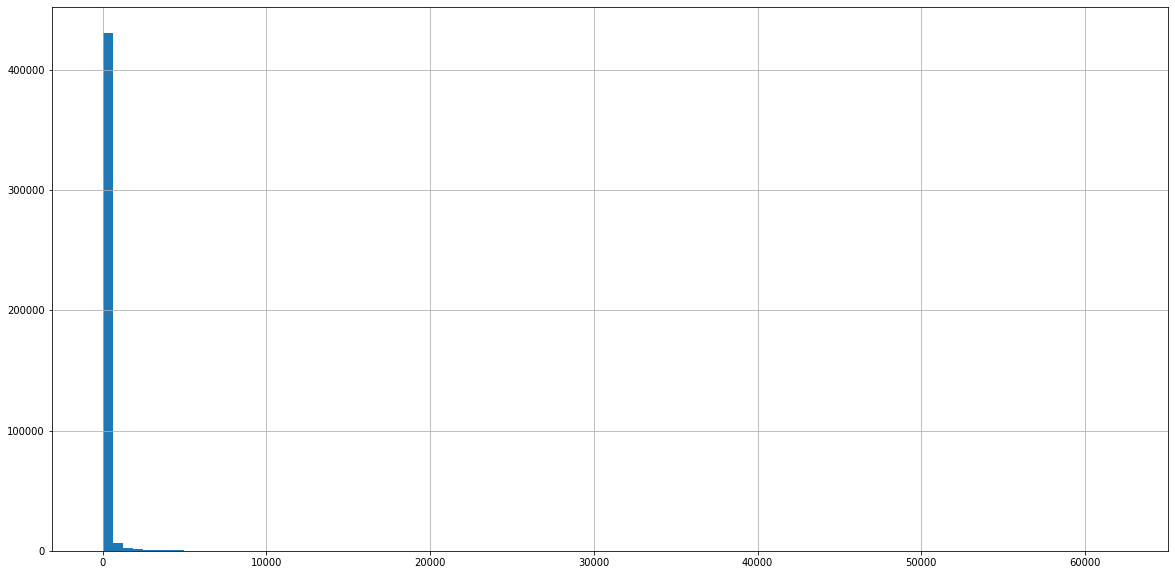

In [12]:
y_train.hist(bins=100, figsize=(20, 10))

In [16]:
y_train[y_train > 10000]

count    444058.000000
mean        103.030570
std         714.950174
min           0.018432
25%           0.328704
50%           2.667008
75%          22.158720
max       61956.699219
Name: time, dtype: float64